In [4]:
import pretty_errors
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from datetime import datetime
from scipy import stats
from IPython.display import IFrame
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # 默认为'last'
plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
plt.style.use("ggplot")
%matplotlib inline

<div class="jumbotron">
    <h1 class="display-1">回归预测</h1>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

## 多元线性回归模型

- 一种预测建模技术
- 研究一个或多个自变量与**一个**因变量之间的显著关系
- 展示自变量对因变量的影响强度
- 通过已经建立的回归模型预测新的目标值

### 模型表述

- 假设数据集有$d$个特征，对于第$i$个样本，特征为集合$\{x_{1}^{(i)},x_{2}^{(i)},\cdots,x_{d}^{(i)}\}$，则该样本的预测结果$\hat{y}^{(i)}$可以表示为

$$
\hat{y}^{(i)}=w_1x_{1}^{(i)}+w_2x_{2}^{(i)}+\cdots+w_dx_{d}^{(i)}+b
\label{eq:lineareqn}
$$

- 第$i$个样本的所有特征用向量$\boldsymbol{x}_i\in\mathbb{R}^d$表示，所有权重用向量$\boldsymbol{w}\in \mathbb{R}^d$表示，则式\eqref{eq:lineareqn}可用向量表示为

$$
\hat{y}^{(i)}=\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b
\label{eq:linearvec}
$$

- 全部数据集（含有$n$个样本）的特征用矩阵$\mathbf{X}\in\mathbb{R}^{n\times d}$表示，所有样本的预测值用向量$\hat{\boldsymbol{y}}\in\mathbb{R}^n$表示，则线性模型可表示为

$$
\hat{\boldsymbol{y}}=\mathbf{X}\boldsymbol{w}+b 
\label{eq:linearmatrix}
$$

- 线性模型的目标是求解**模型参数**（model parameters）
    - $\boldsymbol{w}$
    - $b$

### 模型求解

\begin{definition}\label{def:lossfun}
损失函数（loss function）：量化目标的实际值与预测值之间的差距。
\end{definition}

- 通常选择**非负数**作为损失，且**数值越小表示损失越小**，完美预测时的损失为0

- 对于线形模型\eqref{eq:linearvec}，真实值为$y^{(i)}$，预测值为$\hat{y}^{(i)}$，可以用**平方误差**函数作为损失函数

$$l^{(i)}(\boldsymbol{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

- 为度量模型在整个数据集上的质量，需计算在训练集$n$个样本上的损失均值，即

$$L(\boldsymbol{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\boldsymbol{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\boldsymbol{w}^\top \boldsymbol{x}^{(i)} + b - y^{(i)}\right)^2.$$

- 线形模型\eqref{eq:linearmatrix}的优化目标为

$$\boldsymbol{w}^*, b^* = \operatorname*{argmin}_{\boldsymbol{w}, b}\  L(\boldsymbol{w}, b).
\label{eq:linearobj}
$$

- 最优解为
$$\hat{\boldsymbol{w}}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{y}$$

- 若为一元线性回归，则系数为，
$$w=\frac{\rm{Cov}({\mathbf{X},\mathbf{y}})}{\rm{Var}({\mathbf{X}})}$$

###  房价受到哪些因素影响？

#### 读入数据

In [5]:
bostonDf = pd.read_csv('./data/analysis/boston.csv')
bostonDf.head()
bostonDf.shape

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


(506, 14)

变量|含义
---|---
CRIM|犯罪率
ZN|住宅用地所占比例
INDUS|城镇中非住宅用地所占比例
CHAS|虚拟变量
NOX|环保指数
RM|每栋住宅的房间数
AGE|1940年以前建成的自住单位的比例
DIS|距离5个波士顿的就业中心的加权距离
RAD|距离高速公路的便利指数
TAX|每一万美元的不动产税率
PTRATIO|城镇中的教师学生比例
B|城镇中的黑人比例
LSTAT|地区中有多少房东属于低收入人群
MEDV|自住房屋房价中位数（即均价）

#### 数据预处理

##### 重复值

In [28]:
bostonDf.duplicated().unique()

array([False])

- 结论：该数据集没有重复记录。

##### 缺失值

In [29]:
bostonDf.isna().sum(axis=0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

- 该数据集没有缺失值。

#### 一元线性回归

##### 可视化各个因素与房价之间的关系

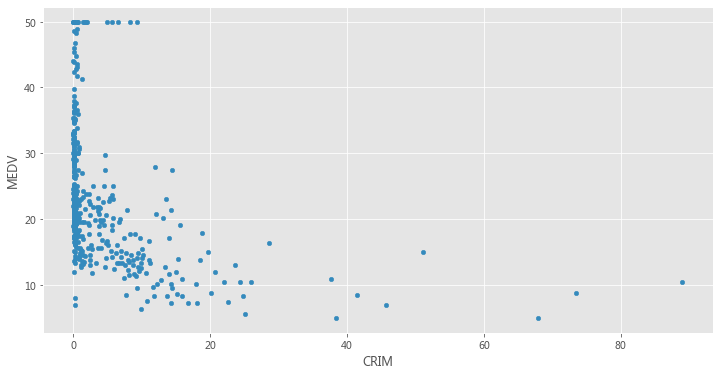

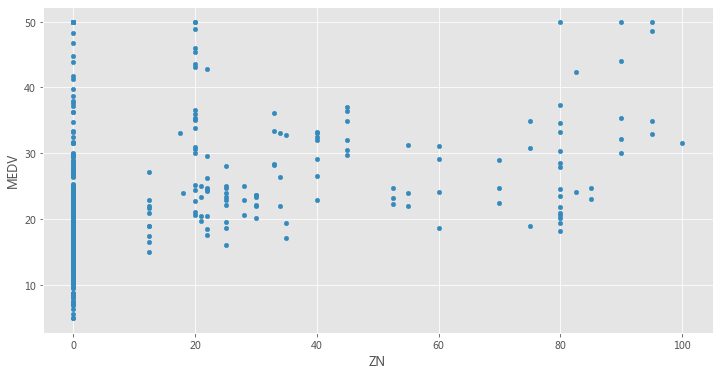

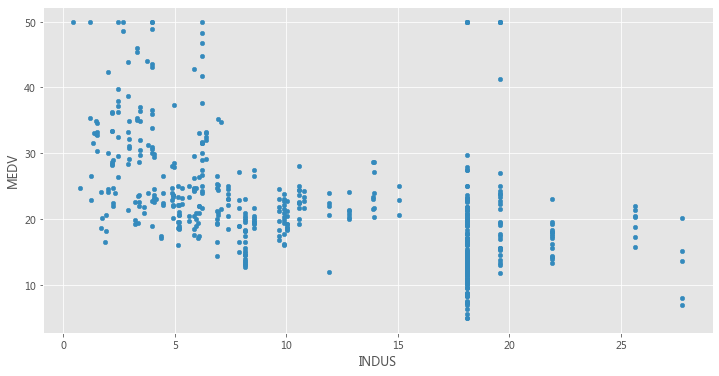

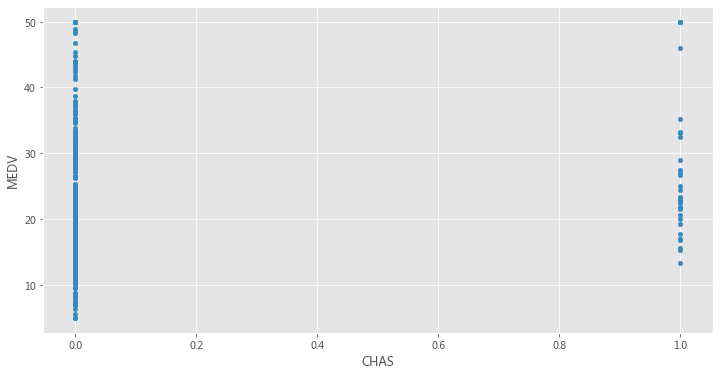

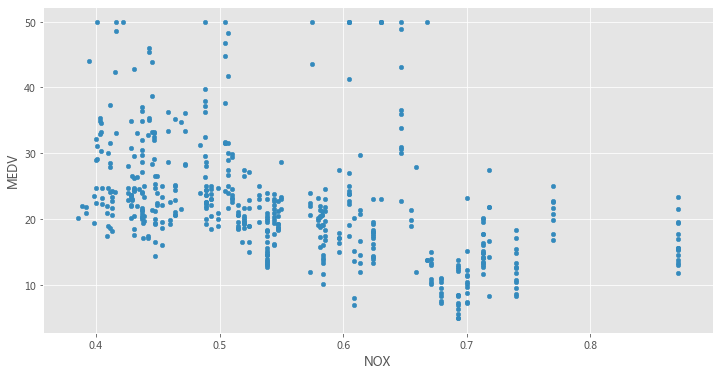

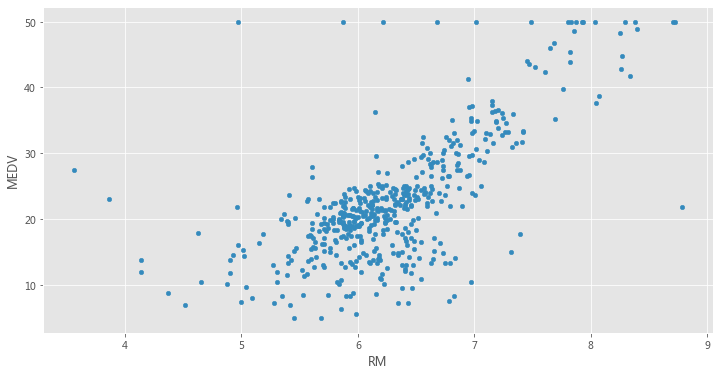

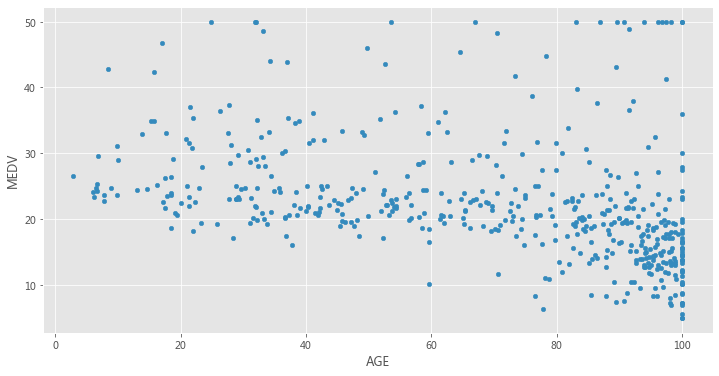

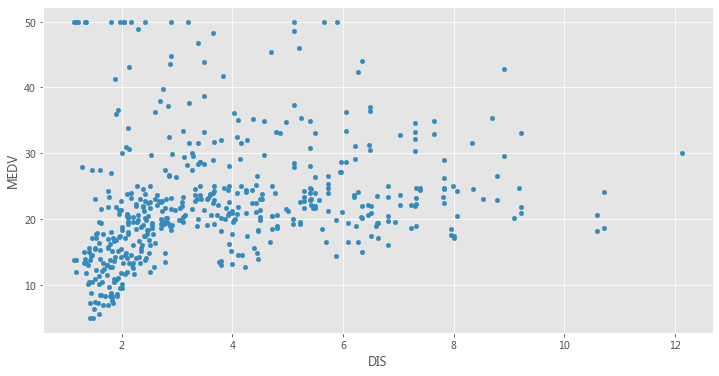

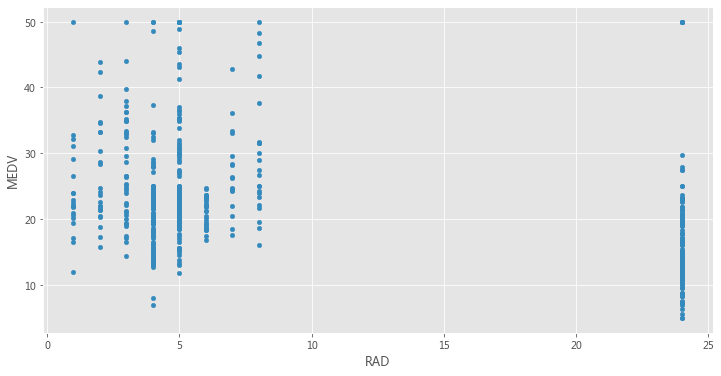

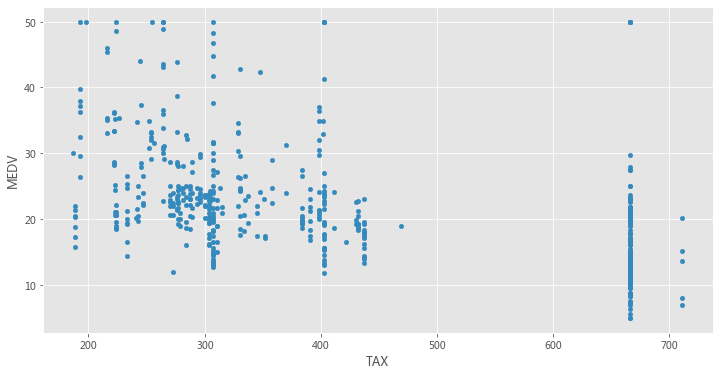

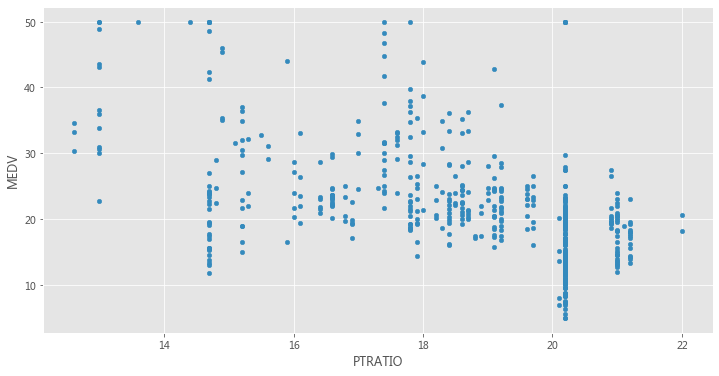

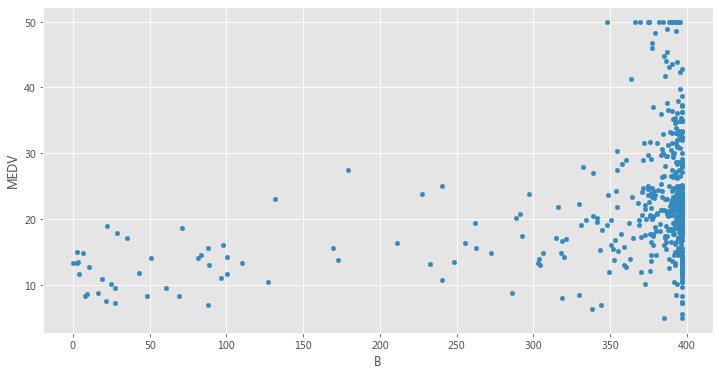

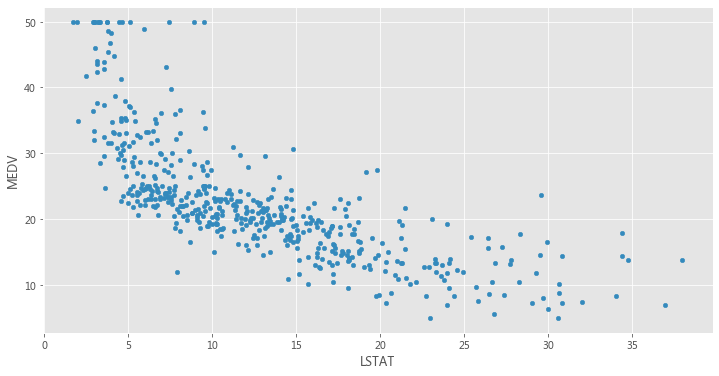

In [31]:
for each in bostonDf.columns[:-1]:
    _ = bostonDf.plot(x=each, y='MEDV', kind='scatter', figsize=(12, 6))

<dl class="row alert-info">
    <dt class="col-md-2">假设6：</dt>
    <dd class="col-md-10">房屋的房间数量能够显著提升房价。</dd>
</dl>
<dl class="row alert-danger">
    <dt class="col-md-2">假设7：</dt>
    <dd class="col-md-10">地区中房东属于低收入人群的数量能够显著降低房价。</dd>
</dl>

##### 建立回归模型

```python
stats.linregress(x,y)
```
- 进行最小二乘回归，`x`为自变量，`y`为因变量
- 返回回归系数、截距、$R$相关系数、$p$值、标准误

In [32]:
rmb1, rmb0, rmr, rmpv, _ = stats.linregress(bostonDf['RM'], bostonDf['MEDV'])
print(f'房屋数量的回归系数是{rmb1:.3f}，p值是{rmpv:.3f}, 回归方程的截距是{rmb0:.3f}，R-squared是{rmr**2:.3f}')

房屋数量的回归系数是9.102，p值是0.000, 回归方程的截距是-34.671，R-squared是0.484


In [33]:
lstb1, lstb0, lstr, lstpv, _ = stats.linregress(bostonDf['LSTAT'], bostonDf['MEDV'])
print(f'房屋房间数量的回归系数是{lstb1:.3f}，p值是{lstpv:.3f}, 回归方程的截距是{lstb0:.3f}，R-squared是{lstr**2:.3f}')

房屋房间数量的回归系数是-0.950，p值是0.000, 回归方程的截距是34.554，R-squared是0.544


##### 计算拟合值

$$
\hat{y} = \beta_1\times x + \beta_0
$$

In [34]:
bostonDf['rmMedv'] = rmb1*np.array(bostonDf['RM'])+rmb0
bostonDf['lstMedv'] = lstb1*np.array(bostonDf['LSTAT'])+lstb0
bostonDf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,rmMedv,lstMedv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,25.175746,29.822595
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,23.774021,25.870390
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,30.728032,30.725142
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,29.025938,31.760696
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,30.382152,29.490078


##### 绘制回归线

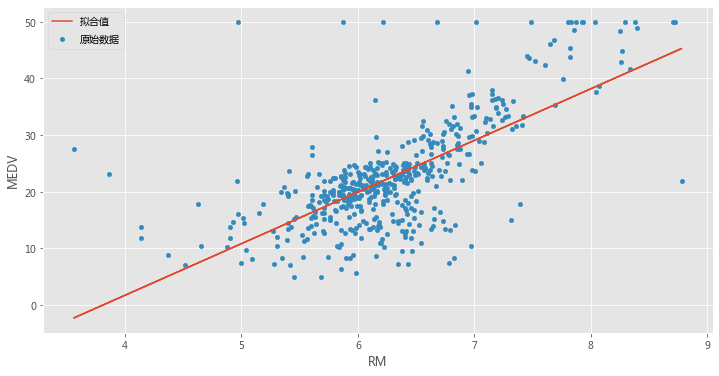

In [36]:
axrm = bostonDf.plot(x='RM', y='MEDV', kind='scatter',
                     figsize=(12, 6), label='原始数据')
_ = bostonDf.plot(x='RM', y='rmMedv', kind='line', label='拟合值', ax=axrm)
_ = axrm.legend()

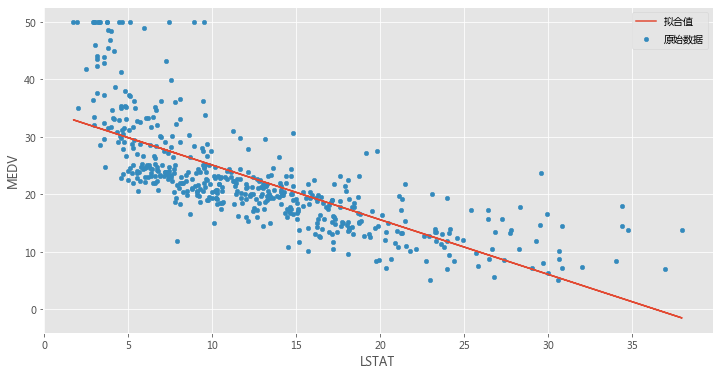

In [37]:
axlst = bostonDf.plot(x='LSTAT', y='MEDV', kind='scatter',
                      figsize=(12, 6), label='原始数据')
_ = bostonDf.plot(x='LSTAT', y='lstMedv', kind='line', label='拟合值', ax=axlst)
_ = axlst.legend()

- 结论：假设6成立，房屋的房间数量越多，房价越高。

- 结论：假设7成立，地区中房东属于低收入人群的数量越多，房价越低。

#### 多元线性回归

```python
import statsmodels.formula.api as smf
```

```python
# 构建模型
md = smf.ols(formula,data,subset)
```
- `formula`：`str`类型，描述公式
- `data`：`pandas.DataFrame`
- `subset`：布尔、整数、索引数组，指定原始数据中的子集用于回归分析
- `md`：返回的是`model`实例

```python
# 拟合数据
res = md.fit()
```

```python
# 显示结果
print(res.summary())
```

In [70]:
resBoston = smf.ols('MEDV~RM+LSTAT+CRIM+NOX+RAD',data=bostonDf, subset=bostonDf['RAD'] > 20).fit()
resBoston.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     38.61
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           4.08e-21
Time:                        11:12:07   Log-Likelihood:                -417.38
No. Observations:                 132   AIC:                             844.8
Df Residuals:                     127   BIC:                             859.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1002      0.013      7.833      0.000       0.075       0.126
RM            -2.0489      0.772     -2.653      0.009      -3.577      -0.521
LSTAT         -0.8552      0.085    -10.019      0.000      -1.024      -0.686
CRIM          -0.1001      0.041     -2.417      0.017      -0.182      -0.018
NOX          -17.6968      8.527     -2.075      0.040     -34.570      -0.823
RAD            2.4053      0.307      7.833      0.000       1.798       3.013
==============================================================================
Omnibus:                       78.117   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.295
Skew:                           2.197   Prob(JB):                     1.55e-73
Kurtosis:                       9.454   Cond. No.                     4.63e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.24e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### sklearn建模

#### 划分训练集与检验集

In [6]:
from sklearn.model_selection import train_test_split
bsTrainX, bsTestX, bsTrainY, bsTestY = train_test_split(bostonDf.iloc[:,:bostonDf.shape[1]-1],bostonDf['MEDV'],test_size=0.3,random_state=100)

#### 建立模型

In [7]:
from sklearn import linear_model
bstLearModel = linear_model.LinearRegression()
bstLearModel

LinearRegression()

#### 训练模型

In [8]:
bstLearModel.fit(bsTrainX,bsTrainY)

LinearRegression()

##### 得到回归系数与截距

- 回归系数：`bstLearModel.coef_`
- 截距：`bstLearModel.intercept_`

In [9]:
print(f'回归系数为{[round(x,3) for x in bstLearModel.coef_]}')
print(f'截距为{bstLearModel.intercept_:.3f}')

回归系数为[-0.077, 0.04, -0.006, 2.63, -13.142, 3.844, -0.012, -1.376, 0.284, -0.014, -0.919, 0.011, -0.438]
截距为33.116


#### 预测

In [11]:
predicted = bstLearModel.predict(bsTrainX)
resDf = pd.DataFrame({'原价格':bsTrainY,'预测价格':predicted})
resDf

,原价格,预测价格
463,20.2,21.836585
75,21.4,23.495847
478,14.6,18.784720
199,34.9,29.445246
84,23.9,24.957573
...,...,...
343,23.9,27.180265
359,22.6,19.097343
323,18.5,19.494229
280,45.4,38.031242


### 拟合度

##### 决定系数$R^2$

$$R^2(y,\hat{y})=1-\frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}$$

其中，$\hat{y}_i$为预测值，$\bar{y}$为均值

In [12]:
# 训练集的R2
bstR2 = bstLearModel.score(bsTrainX,bsTrainY)
print(f'训练集的R-square为{bstR2:.3f}')

回归的R-square为0.753


In [13]:
bstR2Test = bstLearModel.score(bsTestX,bsTestY)
print(f'检验集的R-square为{bstR2Test:.3f}')

检验集的R-square为0.706


##### 平均绝对误差 mean absolute error (MAE)

$$\rm{MAE}(y,\hat{y})=\frac{1}{n}\sum_{i=1}^n|y_i-\hat{y}_i|$$

In [14]:
from sklearn.metrics import mean_absolute_error
# 训练集的MAE
bstMAE = mean_absolute_error(bsTrainY,bstLearModel.predict(bsTrainX))
print(f'训练集的MAE为{bstMAE:.3f}')
# 检验集的MAE
bstMAETest = mean_absolute_error(bsTestY,bstLearModel.predict(bsTestX))
print(f'训练集的MAE为{bstMAETest:.3f}')

训练集的MAE为3.127
训练集的MAE为3.472


##### 平均绝对百分比误差 mean absolute percentage error (MAPE)

$$\rm{MAPE}(y,\hat{y})=\frac{1}{n}\sum_{i=1}^n\frac{|y_i-\hat{y}_i|}{\max(\epsilon,|y_i|)}$$

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
# 训练集的MAE
bstMAPE = mean_absolute_percentage_error(bsTrainY,bstLearModel.predict(bsTrainX))
print(f'训练集的MAE为{bstMAPE:.3f}')
# 检验集的MAE
bstMAPETest = mean_absolute_percentage_error(bsTestY,bstLearModel.predict(bsTestX))
print(f'训练集的MAE为{bstMAPETest:.3f}')

训练集的MAE为0.157
训练集的MAE为0.171


##### 均方误差 mean squared error (MSE)

$$\rm{MSE}(y,\hat{y})=\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

In [15]:
from sklearn.metrics import mean_squared_error
# 训练集的MAE
bstMSE = mean_squared_error(bsTrainY,bstLearModel.predict(bsTrainX))
print(f'训练集的MAE为{bstMSE:.3f}')
# 检验集的MAE
bstMSETest = mean_squared_error(bsTestY,bstLearModel.predict(bsTestX))
print(f'训练集的MAE为{bstMSETest:.3f}')

训练集的MAE为19.067
训练集的MAE为29.799


## 逻辑回归

- logistic regression

- 因变量是**二元**变量(binary response)

### 线性回归的问题

<center>
    <img src='./img/analysis/linearRegBinaryRep.jpg' width=70%>
</center>

- 期望的预测结果

<center>
    <img src='./img/analysis/logistReg.jpg' width=70%>
</center>

### 逻辑回归的原理

令$\pi$表示事件{Y=1}发生的概率，$\mathbf{\beta}$为回归系数向量，则

$$
\pi = \frac{\rm{e}^{\mathbf{\beta^T X}}}{1+\rm{e}^{\mathbf{\beta^T X}}}=\frac{1}{1+\rm{e}^{-\mathbf{\beta^T X}}}
$$

- 上式即为sigmoid函数

- 转变为$\mathbf{\beta^T X}$的线性函数

$$
\log\frac{\pi}{1-\pi}=\mathbf{\beta^T X}
$$

- $\frac{\pi}{1-\pi}$被称为odds

- $\log\frac{\pi}{1-\pi}$被称为log odds

##### 极大似然估计参数（maximum likelihood）

- 优化模型参数以最大可能得到样本数据

- 即样本数据发生的概率最大

- 假设有$n$个样本，则样本发生的概率

$$
P\{Y_1=y_1,Y_2=y_2,\cdots,Y_n=y_n\}=P\{Y_1=y_1\}P\{Y_2=y_2\}\cdots P\{Y_n=y_n\}
$$

- 二元因变量服从二项分布

$$
\max \Pi_{i=1}^n\; \pi_i^{y_i}(1-\pi_i)^{1-y_i}
$$

令$L=\Pi_{i=1}^n\; \pi_i^{y_i}(1-\pi_i)^{1-y_i}$，则
$$
l = \log(L)=\sum_{i=1}^n\left(y_i\mathbf{\beta^T X_i}-\log(1+\rm{e}^{\mathbf{\beta^T X_i}})\right)
$$

- 逻辑回归系数含义
    - 令$\beta_i$为第$i$个自变量的回归系数

$$
\frac{\frac{\pi'}{1-\pi'}}{\frac{\pi}{1-\pi}}=\rm{e}^{\beta_i}
$$

- 上式左侧为odds ratio

##### 逻辑回归建模

```python
# 构建模型
md = smf.logit(formula,data,subset)

# 拟合数据
res = md.fit()

# 显示结果
res.summary()
```

In [72]:
resTitanic = smf.logit('Survived~Fare+Age+Pclass',
                       data=titanicDf, subset=titanicDf['Sex'] == 'male').fit()
resTitanic.summary()

Optimization terminated successfully.
         Current function value: 0.456499
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  453
Model:                          Logit   Df Residuals:                      449
Method:                           MLE   Df Model:                            3
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.1008
Time:                        11:22:42   Log-Likelihood:                -206.79
converged:                       True   LL-Null:                       -229.97
Covariance Type:            nonrobust   LLR p-value:                 4.774e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9457      0.631      3.083      0.002       0.709       3.183
Fare           0.0019      0.003      0.765      0.444      -0.003       0.007
Age           -0.0447      0.010     -4.520      0.000      -0.064      -0.025
Pclass        -0.9236      0.185     -4.996      0.000      -1.286      -0.561
==============================================================================
"""